# Groundwater notebook

The Groundwater model describes the dynamics of the subsurface water at the county-scale. The two main phenomenon are the evolution of piezometric head (function of recharge, withdrawals and lateral flows) and the lateral flows (exchange of flow due to the difference in head between two adjacent counties).

### The aquifer component

In [1]:
using Mimi
@defcomp Aquifer begin
  aquifers = Index()

  # Aquifer description
  depthaquif = Parameter(index=[aquifers], unit="1 m")
  areaaquif = Parameter(index=[aquifers], unit="1000 m^2")
  storagecoef = Parameter(index=[aquifers], unit="none")
  drawdown0 = Parameter(index=[aquifers], unit="1 m") # used for initialisation
  
  # Recharge
  recharge = Parameter(index=[aquifers, time], unit="1000 m^3")

  # Withdrawals - to be optimised
  withdrawal = Parameter(index=[aquifers, time], unit="1000 m^3")

  # Lateral flows
  lateralflows = Variable(index=[aquifers, time], unit="1000 m^3")
  aquiferconnexion = Parameter(index=[aquifers, aquifers], unit ="none") # aquiferconnexion[aa,aa']=1 -> aquifers are connected, 0 otherwise.
  lateralconductivity = Parameter(index=[aquifers, aquifers], unit="1 m^2/month") ## how should I specify per month per year?
  deltatime = Parameter(unit="month")

  # Piezometric head
  drawdown = Variable(index=[aquifers, time], unit="1 m")

  # Unit volume cost
  volumetriccost = Variable(index=[aquifers, time], unit="\$/1000 m^3")
end

Aquifer

### Model equations

The two equations at the heart of the component are the one describing the evolution of the piezometric head (measured as the distance between the county elevation and the water table - drawdown would be more appropriate):

piezohead[a,t] = piezohead[a,t-1] + 1/(storagecoef[a]*areaaquif[a])*(- recharge[a,t] + withdrawal[a,t] + lateralflows[a,t])

And the one describing the lateral flows:

lateralflows[a,t] = \sum_{a\*} lateralconductivity[a,a\*] \* (piezohead[a\*,tt-1]-piezohead[a,tt-1])

### Functions

Groundwater.jl contains a serie of functions:
    - The timestep function computes the variables evolution using the two precedently described equations
    - The constraints functions min and max ensure that the drawdown > 0 (non-artesian well) and drawdown < depthaquifer (i.e. confined aquifers remain confined and unconfined aquifer can entirely depleted)
    - The initialisation function initaquifercontus to set the component and describe the subsurface for all of CONTUS at a county-scale

In [2]:
function timestep(c::Aquifer, tt::Int)
  v = c.Variables
  p = c.Parameters
  d = c.Dimensions
  # computation of lateral flows:
  v.lateralflows[:,tt]=zeros(d.aquifers[end],1)
  for aa in 1:d.aquifers[end]
    for aa_ in (aa+1):(d.aquifers[end]-1)
      if p.aquiferconnexion[aa,aa_]==1.
        if tt==1
        latflow = p.lateralconductivity[aa,aa_]*(p.drawdown0[aa_]-p.drawdown0[aa])*p.deltatime; # in m3/month or m3/year if factor 12
        else
        latflow = p.lateralconductivity[aa,aa_]*(v.drawdown[aa_,tt-1]-v.drawdown[aa,tt-1])*p.deltatime; # in m3/month or m3/year if factor 12
        end
        v.lateralflows[aa,tt] +=   latflow/1000;
        v.lateralflows[aa_,tt] += -latflow/1000;
      end
    end
  end

    # drawdown initialisation and simulation
  for aa in d.aquifers
    if tt==1
      v.drawdown[aa,tt] = p.drawdown0[aa] + 1/(p.storagecoef[aa]*p.areaaquif[aa])*(- p.recharge[aa,tt] + p.withdrawal[aa,tt] + v.lateralflows[aa,tt])
    else
      v.drawdown[aa,tt] = v.drawdown[aa,tt-1] + 1/(p.storagecoef[aa]*p.areaaquif[aa])*(- p.recharge[aa,tt] + p.withdrawal[aa,tt] + v.lateralflows[aa,tt])
    end
  end

  # variable to pass to watercost component. assumption: piezohead does not vary much and it's initial value is representative. piezohead datum is sea level
  for aa in d.aquifers
    v.volumetriccost[aa,tt] = p.drawdown0[aa]
  end
end

timestep (generic function with 3 methods)

### Subsurface model

*illustrations and description to come*

### Data

*work in progress*

USGS data collected and formatted by Tess Russo are used to represent the main aquifers. In its current form, five aquifers are currently represented: the Central Valley, the Columbia Plateau, the High Plains, the Mississippi Embayment, and the Powder Williston. For regions in between those aquifers, permeability values from Gleeson (2012) are used to populate the model.

Illustrations can be found here: https://www.dropbox.com/sh/jk7m0f9nxdg7rxt/AABTnfCGL_CEZL8Zu0txxRJza?dl=0

### One year simulation run

In [3]:
using OptiMimi
using DataFrames
include("../src/Allocation.jl")
include("../src/Groundwater.jl")

initaquifercontus (generic function with 1 method)

In [4]:
println("Creating model...")
m = Model();

ncounty= 3109;
setindex(m, :time, collect(1));
setindex(m, :regions, collect(1:ncounty));
setindex(m, :aquifers, collect(1:ncounty));
setindex(m, :canals, collect(1:ncounty));
# Add all of the components
allocation = initallocation(m);
aquifer = initaquifercontus(m);
# Set links between components
aquifer[:withdrawal] = allocation[:watergw];

# Run it and time it!
@time run(m)

Creating model...
  0.562202 seconds (146.51 k allocations: 6.800 MB)


-----------------------------------------------------------
PBS Mapping 2.69.76 -- Copyright (C) 2003-2016 Fisheries and Oceans Canada

PBS Mapping comes with ABSOLUTELY NO WARRANTY;
for details see the file COPYING.
This is free software, and you are welcome to redistribute
it under certain conditions, as outlined in the above file.

A complete user guide 'PBSmapping-UG.pdf' is located at 
/Library/Frameworks/R.framework/Versions/3.3/Resources/library/PBSmapping/doc/PBSmapping-UG.pdf

Packaged on 2015-04-23
Pacific Biological Station, Nanaimo

All available PBS packages can be found at
http://code.google.com/p/pbs-software/

To see demos, type '.PBSfigs()'.
-----------------------------------------------------------




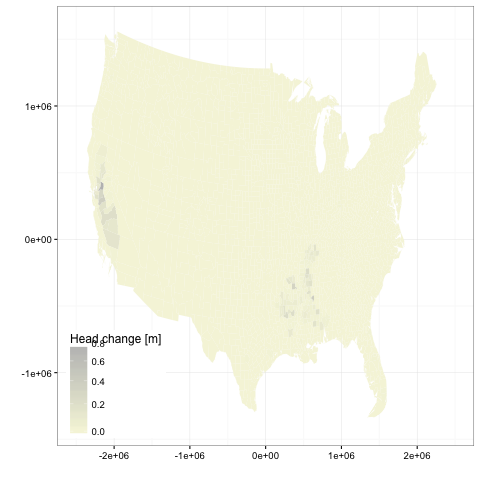

Loading required package: sp
Checking rgeos availability: TRUE
Loading required package: foreign


In [5]:
using RCall
R"library(ggplot2)"
R"library(PBSmapping)"
R"shapes <- importShapefile('../data/mapping/US_county_2000-simple')";
R"polydata <- attributes(shapes)$PolyData";
R"polydata$STATE <- as.numeric(levels(polydata$STATE))[polydata$STATE]";
R"polydata$COUNTY <- as.numeric(levels(polydata$COUNTY))[polydata$COUNTY]";
R"shapes$id <- polydata$STATE[shapes$PID]*100 + polydata$COUNTY[shapes$PID]/10";
R"names(shapes) <- tolower(names(shapes))";
recorded = readtable("../data/extraction/USGS-2010.csv");

diffdrawdown = -m.components[:Aquifer].Parameters.drawdown0+m.components[:Aquifer].Variables.drawdown;
recorded[:diffdwn] = diffdrawdown[1:3109];

#R"pdf('../results/drawdown_oneyear_use.pdf')";
R"print(ggplot($recorded, aes(fill=diffdwn)) + geom_map(aes(map_id=FIPS), map=shapes) + expand_limits(x=c(-2500000, 2500000), y=c(-1.4e6, 1.6e6)) + scale_fill_gradient(name='Head change [m]', trans='log1p', low='beige', high='grey', breaks=c(0,0.2,0.4,0.6,0.8,1)) + theme_bw() + theme(legend.justification=c(0,0), legend.position=c(0,0)) + xlab('') + ylab(''))";

Change in piezometric head due to one year of groundwater exploitation. This estimate is based on withdrawals data from USGS for the year 2010 for the industrial, mining and public-supply sector.